# <center> Θέμα:  Εκτίμηση Οπτικής Ροής (Optical Flow) και Εξαγωγή Χαρακτηριστικών σε Βίντεο για Αναγνώριση Δράσεων
## <center>  Μέρος 1: Παρακολούθηση Προσώπου και Χεριών με Χρήση της Μεθόδου Οπτικής Ροής των Lucas-Kanade

In [2]:
from scipy.stats import multivariate_normal
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label,map_coordinates,convolve1d, rank_filter
from numpy import unravel_index
import math
import glob
import base64
from numpy.linalg import norm
import cv21_lab2_2_utils as utils
import os
%matplotlib inline

## <center> 1.1 Ανίχνευση Δέρματος Προσώπου και Χεριών 

In [132]:
mat = scipy.io.loadmat('GreekSignLanguage/skinSamplesRGB.mat')
skin_YCbCr = cv2.cvtColor(mat['skinSamplesRGB'], cv2.COLOR_RGB2YCrCb)
Cb = skin_YCbCr[:,:,1] 
Cr = skin_YCbCr[:,:,2]
mu = [np.mean(Cb),np.mean(Cr)]
cov = np.array(np.cov(Cb.flatten(), Cr.flatten()))
print("mu = ", mu)
print("cov = ", cov)

mu =  [157.0460157126824, 103.27048260381594]
cov =  [[ 44.19103128 -11.9310385 ]
 [-11.9310385   11.19574811]]


In [183]:
def fd(I,mu,cov):
    IYCbCr = cv2.cvtColor(I, cv2.COLOR_RGB2YCrCb)
    Cb = IYCbCr[:,:,1]
    Cr = IYCbCr[:,:,2]

    x= np.array( [Cb, Cr] ).T
    P = multivariate_normal.pdf( x , mu, cov)
    P = P.T
    _, skin = cv2.threshold(P, 0.0001, 0.25, cv2.THRESH_BINARY)  
    
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((10,10),np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    plt.imshow(closing,cmap='gray')
    
    labeled_array, num_features = label(closing)
    print(num_features)
    coords = []
    for i in range(num_features):
        x,y = np.where(labeled_array == i+1)
        x = np.sort(x) 
        y = np.sort(y) 
        width = x[-1]-x[0]
        height = y[-1] - y[0]
        coords.append([y[0], x[0],height,width])
    
    return coords

3


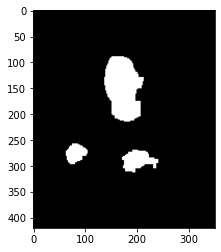

In [184]:
I = cv2.imread("GreekSignLanguage/1.png")
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)  
tmp = fd(I,mu,cov)

r  =  138 88 73 125
g  =  62 256 41 39
b  =  172 268 67 39


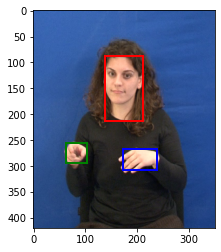

In [166]:
figure, ax = plt.subplots(1)
colors = ['r','g','b']
for i in range(3):
    ax.add_patch(patches.Rectangle((tmp[i][0],tmp[i][1]),tmp[i][2],tmp[i][3], edgecolor=colors[i], facecolor="none",linewidth=2))
    print(colors[i]," = ", tmp[i][0],tmp[i][1],tmp[i][2],tmp[i][3])
ax.imshow(I)
plt.show()

## <center> 1.2 Παρακολούθηση Προσώπου και Χεριών

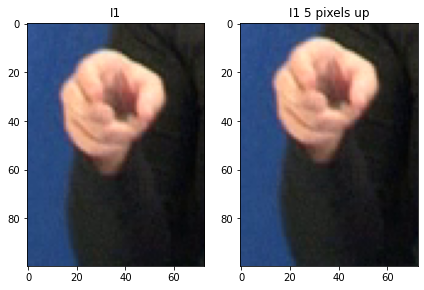

In [7]:
img = cv2.imread('GreekSignLanguage/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
I1 = img[243:243+100, 47:47+73]
I2 = img[243+5:243+100+5, 47:47+73]
I1gray = cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY)
I2gray = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)


f, axarr = plt.subplots(1,2, figsize=(7, 7))
axarr[0].imshow(I1)
axarr[0].title.set_text('I1')
axarr[1].imshow(I2)
axarr[1].title.set_text('I1 5 pixels up')

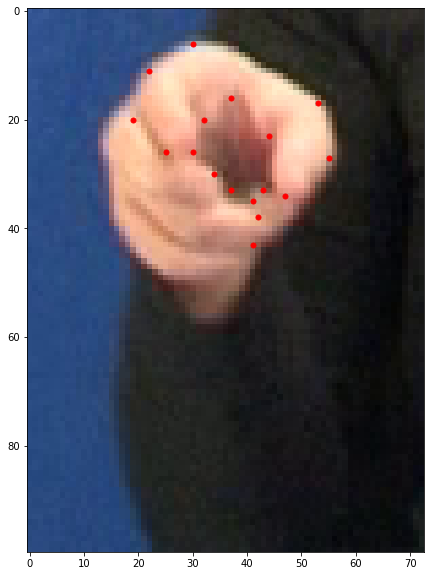

In [8]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 20,
                       qualityLevel = 0.2,
                       minDistance = 2,
                       blockSize = 5)
gray = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)
p0 = cv2.goodFeaturesToTrack(gray, mask = None, **feature_params)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(I2, cmap=plt.cm.gray)
ax.plot(p0[:,0, 0], p0[:,0, 1], color='red', marker='o', linestyle='None', markersize=5)

plt.show()

### 1.2.1 Υλοποίηση του Αλγόριθμου των Lucas-Kanade

In [130]:
def lucas_kanade(I1, I2, features, rho, epsilon, dx0, dy0):
    
    dx_i = dx0.astype(np.float64)
    dy_i = dy0.astype(np.float64) 
    
    ########### Create meshgrid of the image ################
    
    xx = np.linspace(0,I1.shape[1]-1,I1.shape[1])
    yy = np.linspace(0,I1.shape[0]-1,I1.shape[0]) 
    x0,y0 = np.meshgrid(xx,yy)

    I1 = I1.astype(np.float64)/255
    I2 = I2.astype(np.float64)/255
     
    ############### Calc Gaussian Kernel ####################
    
    n = int(2*np.ceil(3*rho)+1)  
    gauss1D = cv2.getGaussianKernel(n, rho) 
    gauss2D = gauss1D @ gauss1D.T  

    ############# Calc Gradient of the image ################
    
    dy_Iprev, dx_Iprev = np.gradient(I1)
    
    for i in range(30):
        
        ###### Calculate I(x+dx) by interpolation ##########
        Iprev = map_coordinates(I1,[np.ravel(y0 + dy_i),np.ravel(x0 + dx_i)], order=1).reshape(I1.shape)
        A1 = map_coordinates(dx_Iprev,[np.ravel(y0 + dy_i), np.ravel(x0 + dx_i)], order=1).reshape(I1.shape)
        A2 = map_coordinates(dy_Iprev,[np.ravel(y0 + dy_i), np.ravel(x0 + dx_i)], order=1).reshape(I1.shape)
        
        
        E = I2 - Iprev   #E(x) = In - In-1(x+di)
        
        #
        # u(x) = |a11 a12|^(-1)  |b1|
        #       |a21 a22|      * |b2| 
        #
        # |a11 a12|^(-1)  |a22 -a12|
        # |a21 a22|     = |-a21 a11|* 1/det(A)
        #
        #
        
        a11 = cv2.filter2D(A1**2,-1,gauss2D)+epsilon
        a12 = cv2.filter2D(A1*A2,-1,gauss2D)
        a21 = a12
        a22 = cv2.filter2D(A2**2,-1,gauss2D)+epsilon
        
        b1 = cv2.filter2D(A1*E,-1,gauss2D)
        b2 = cv2.filter2D(A2*E,-1,gauss2D)
        
    
        det = (a11*a22 - a12*a21) 
        #
        # det = |a11 a12| = a11*a22 - a21*a12
        #       |a21 a22|
        #
        ux = (a22*b1 - a12*b2) / det
        uy = (a11*b2 - a21*b1) / det


        if features is not None:
            for x,y in features[:,0,:].astype(int):
                dx_i[y][x] = dx_i[y][x] + ux[y][x]
                dy_i[y][x] = dy_i[y][x] + uy[y][x]

    return [dx_i,dy_i]

### 1.2.2 Υπολογισμός της Μετατόπισης των Παραθύρων από τα Διανύσματα Οπτικής Ροής

In [9]:
def displ(d_x, d_y):
    
    threshold = 0.5
    dx = d_x.flatten()
    dy = d_y.flatten()
    d = dx**2 + dy**2
        
    cond = (d >= threshold*np.max(d)).astype(np.uint8).reshape(d_x.shape)
    
    dx = cond*d_x
    dy = cond*d_y
    
    dx_mean = np.sum(dx)/np.sum(cond)
    dy_mean = np.sum(dy)/np.sum(cond)
#     dx_mean = np.mean(dx)
#     dy_mean = np.mean(dy)
    
    return dx_mean, dy_mean

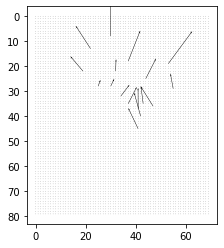

(-1.2656361166346188, 3.373677736008368)


In [131]:
#run lucas kanade for the same image but 3 pixels up

feature_params = dict( maxCorners = 20,
                       qualityLevel = 0.2,
                       minDistance = 2,
                       blockSize = 5)
img = cv2.imread('GreekSignLanguage/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
I1 = img[243:243+80, 47:47+70]
I2 = img[243+3:243+80+3, 47:47+70]
I1gray = cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY)
I2gray = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)
p0 = cv2.goodFeaturesToTrack(I2gray, mask = None, **feature_params)

dx, dy = lucas_kanade(I1gray, I2gray, p0, 5, 0.1,np.zeros_like(I1gray),np.zeros_like(I1gray)) #I1, I2, features, rho, epsilon, dx0, dy0
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal') 
plt.quiver(-dx,-dy,angles='xy',scale=20)
plt.show()
print(displ(dx,dy))

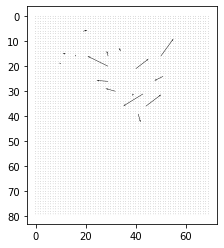

In [16]:
#Run Lucas Kanade for frame1 and frame2
I1 = cv2.imread('GreekSignLanguage/1.png')
I2 = cv2.imread('GreekSignLanguage/2.png')
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)[243:243+80, 47:47+70]
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)[243:243+80, 47:47+70]
p0 = cv2.goodFeaturesToTrack(I2, mask = None, **feature_params)

dx, dy = lucas_kanade(I1, I2, p0, 1, 0.1, np.zeros_like(I1), np.zeros_like(I1)) #I1, I2, features, rho, epsilon, dx0, dy0
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal') 
plt.quiver(-dx,-dy,angles='xy',scale=30)
plt.show()

#### Initialization and testing


In [17]:
rho = 3
epsilon=0.1
feature_params = dict( maxCorners = 20,
                       qualityLevel = 0.2,
                       minDistance = 1,
                       blockSize = 5)

# Parameters to track the left hand
x = 47
y = 243
width = 71
height = 66

# Parameters to track the right hand
# x = 162
# y = 264
# width = 83
# height = 48

# Parameters to track the face
# x = 138
# y = 88
# width = 73
# height = 123

In [280]:
#for each 2 images, run mmlti_li function, to track the movement of Hands/Head (one at a time)
for i in range(1,65):
    path1 = 'GreekSignLanguage/' + str(i) + '.png'
    I1_bgr = cv2.imread(path1)
    I1_gray = cv2.cvtColor(I1_bgr,cv2.COLOR_BGR2GRAY)
    I1 = I1_gray.astype(np.float)/255
    
    
    path2 = 'GreekSignLanguage/' + str(i+1) + '.png'
    I2_bgr = cv2.imread(path2)
    I2_gray = cv2.cvtColor(I2_bgr,cv2.COLOR_BGR2GRAY)
    I2 = I2_gray.astype(np.float)/255
    
    det1 = I1_gray[y:(y+height+20),x:(x+width+20)]
    det2 = I2_gray[y:(y+height+20),x:(x+width+20)]
    
    p0 = cv2.goodFeaturesToTrack(det2, mask = None, **feature_params)
    
    d_x, d_y = lucas_kanade(det1, det2, p0 ,rho, epsilon, np.zeros(det1.shape), np.zeros(det2.shape))
    
    displ_x,displ_y = displ(d_x, d_y)
    displ_x = int(displ_x)
    displ_y = int(displ_y)
    
    
    plt.figure()
    cv2.rectangle(I2_bgr, (x, y), (x+width, y+height), (255,0,0) ,2)
    plt.imshow(I2_bgr)
    x = x - displ_x
    y = y - displ_y

### 1.2.3 Πολυ-Κλιμακωτός Υπολογισμός Οπτικής Ροής

In [11]:
def multi_lk(I1, I2, rho, epsilon, scales):  
    
    for i in range(scales-1):
        I1 = cv2.pyrDown(I1)
        I2 = cv2.pyrDown(I2)
    
    dx = np.zeros_like(I1)
    dy = np.zeros_like(I1)
    
    for i in range(scales):
        p0 = cv2.goodFeaturesToTrack(I2, mask = None, **feature_params)
        dx,dy = lucas_kanade(I1,I2,p0,rho,epsilon,dx,dy)
        I1 = cv2.pyrUp(I1)
        I2 = cv2.pyrUp(I2)
        dx = 2*cv2.resize(dx,( int(np.ceil(dx.shape[1]*2 )) , int(np.ceil(dx.shape[0]*2) )))
        dy = 2*cv2.resize(dy,( int(np.ceil(dy.shape[1]*2 )) , int(np.ceil(dy.shape[0]*2) )))
    
    
    return dx,dy

#### Initialization and testing

In [187]:
rho = 3
epsilon=0.1
feature_params = dict( maxCorners = 20,
                       qualityLevel = 0.2,
                       minDistance = 1,
                       blockSize = 5)

# Parameters to track the left hand
x = 47
y = 243
width = 71
height = 66

# Parameters to track the right hand
# x = 162
# y = 264
# width = 83
# height = 48

# Parameters to track the face
# x = 138
# y = 88
# width = 73
# height = 123

C:\Users\Antreas\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


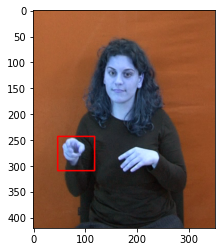

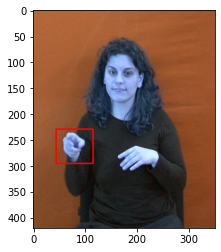

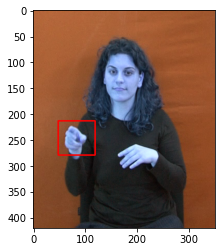

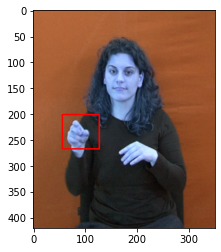

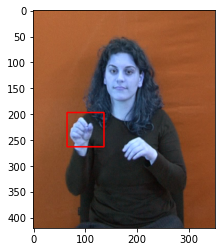

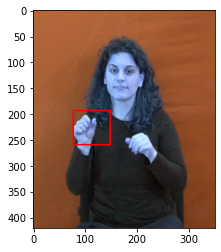

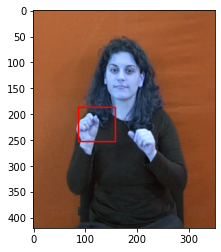

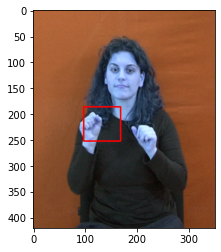

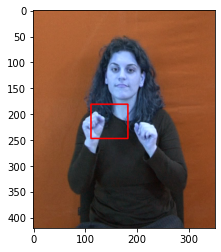

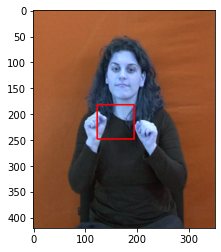

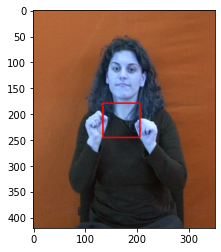

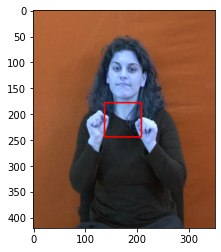

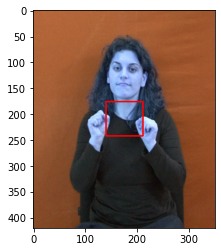

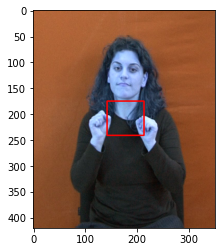

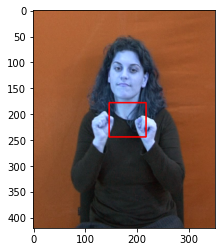

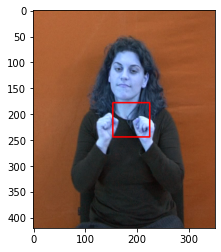

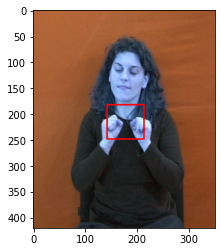

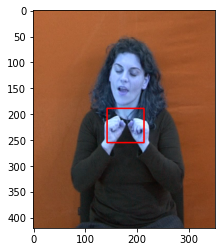

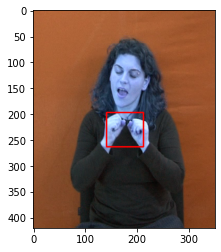

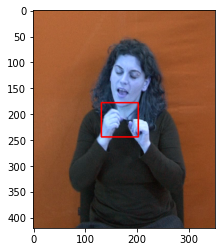

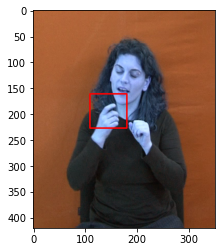

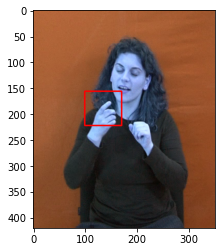

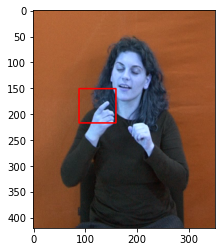

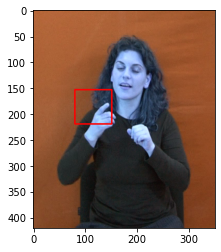

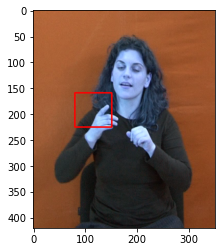

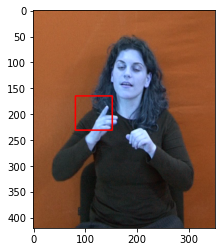

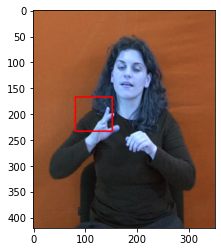

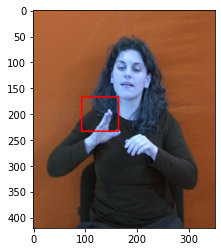

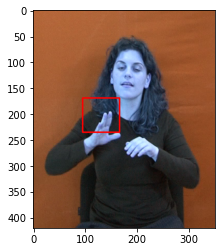

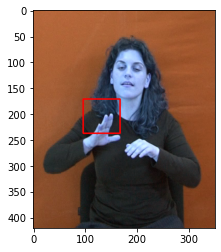

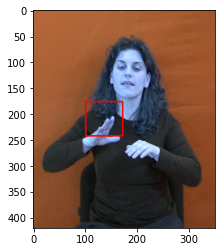

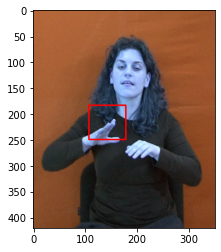

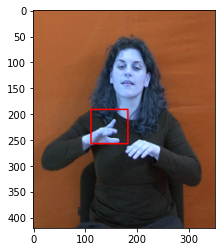

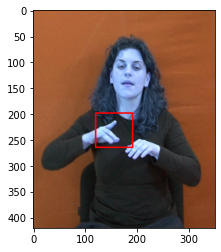

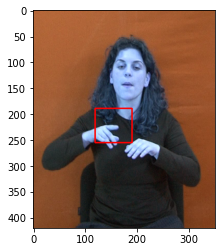

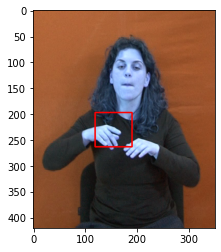

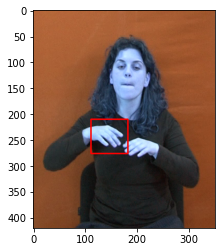

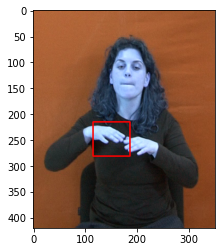

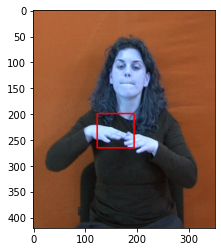

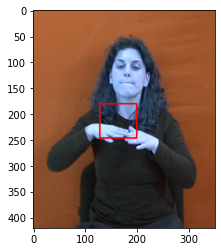

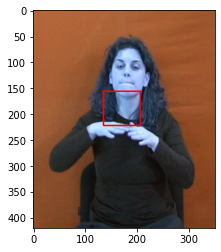

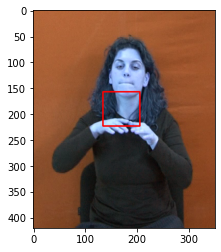

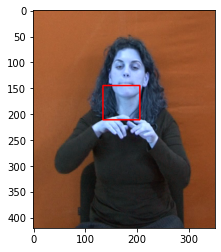

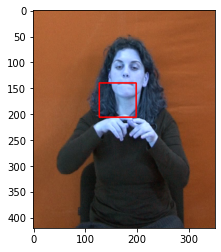

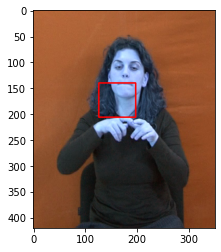

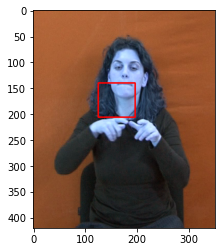

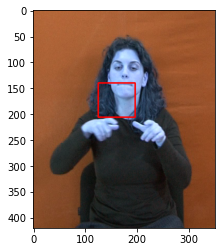

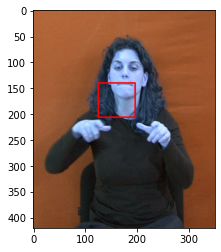

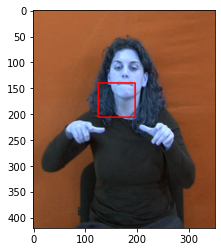

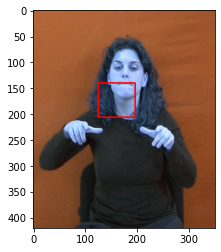

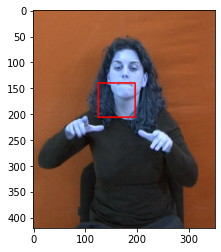

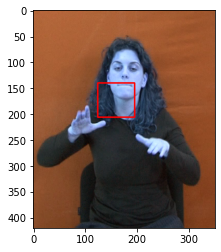

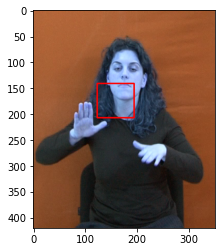

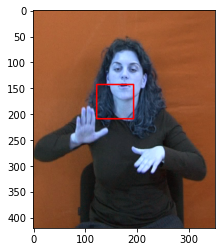

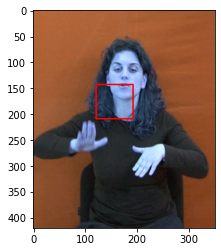

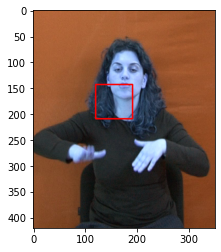

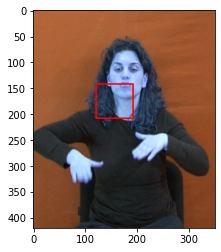

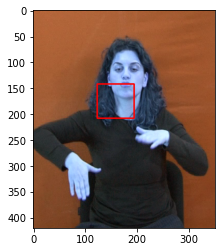

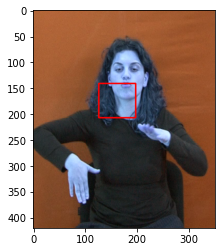

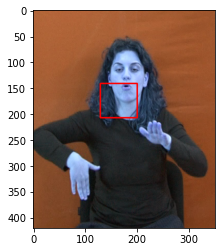

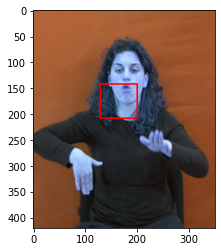

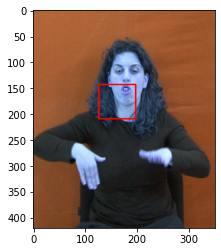

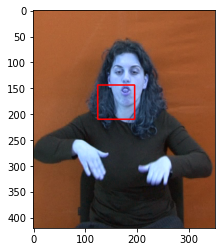

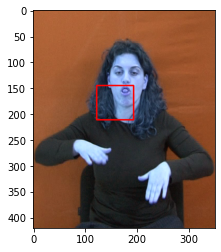

In [188]:
#for each 2 images, run mmlti_li function, to track the movement of Hands/Head (one at a time)
scales = 3
for i in range(1,65):
    path1 = 'GreekSignLanguage/' + str(i) + '.png'
    I1_bgr = cv2.imread(path1)
    I1_gray = cv2.cvtColor(I1_bgr,cv2.COLOR_BGR2GRAY)
    I1 = I1_gray.astype(np.float)/255
    
    
    path2 = 'GreekSignLanguage/' + str(i+1) + '.png'
    I2_bgr = cv2.imread(path2)
    I2_gray = cv2.cvtColor(I2_bgr,cv2.COLOR_BGR2GRAY)
    I2 = I2_gray.astype(np.float)/255
    
    det1 = I1_gray[y:(y+height),x:(x+width)]
    det2 = I2_gray[y:(y+height),x:(x+width)]
    
    d_x, d_y = multi_lk(det1, det2, rho, epsilon, scales)
    
    displ_x,displ_y = displ(d_x, d_y)
    displ_x = int(displ_x)
    displ_y = int(displ_y)
    
    plt.figure()
    cv2.rectangle(I2_bgr, (x, y), (x+width, y+height), (255,0,0) ,2)
    plt.imshow(I2_bgr)
    x = x - displ_x
    y = y - displ_y

# <center> Μέρος 2: Εντοπισμός Χωροχρονικών Σημείων Ενδιαφέροντος και Εξαγωγή Χαρακτηριστικών σε Βίντεο Ανθρωπίνων Δράσεων

In [12]:
# function from lab1, for HarrisDetector
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

## <center> 2.1 Χωροχρονικά σημεία ενδιαφέροντος

In [13]:
# A fucntion to merge the new images into a video
# Jupyter sorts the images in a weird way, thus the video is not in order
def create_play_videoFile(filePath, outName):
    
    img_array = []
    for filename in glob.glob('Lab2_part2/'+filePath+'/*.png'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    out = cv2.VideoWriter('Lab2_part2/' + outName,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    cap = cv2.VideoCapture('Lab2_part2/' + outName)
    while(cap.isOpened()):
        ret,frame = cap.read()
        if ret:
            cv2.imshow('frame',frame)
            cv2.waitKey(0) 
        else:
            break
    cv2.destroyWindow('frame')

### 2.1.1 Harris Detector: Επέκταση του corner_detection function του 1ου εργαστηρίου (Harris-Stephens)

In [135]:
# In our function taf = sigma
def HarrisDetector(video, sigma, rho, k, theta_corn): 
    vod = video.astype(np.float)/255
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    Gs = gaussian @ gaussian.T
    Is = cv2.filter2D(vod, -1, Gs)
    
    ###########################
    
    n = int(np.ceil(3*rho)*2+1)
    gaussian = cv2.getGaussianKernel(n,rho) 
    Grho = gaussian @ gaussian.T
    
    ###########################
    
    [Lx,Ly,Lt]=np.gradient(Is) #Image changes in time due to being a video 
    
    
    ## We could also do convolve video with [-1,0,1] to get Lx,Ly,Lt ##
    
    Lxx = cv2.filter2D(cv2.filter2D(Lx*Lx, -1, Grho), -1, Gs)
    Lxy = cv2.filter2D(cv2.filter2D(Lx*Ly, -1, Grho), -1, Gs)
    Lxt = cv2.filter2D(cv2.filter2D(Lx*Lt, -1, Grho), -1, Gs)
    Lyy = cv2.filter2D(cv2.filter2D(Ly*Ly, -1, Grho), -1, Gs)
    Lyt = cv2.filter2D(cv2.filter2D(Ly*Lt, -1, Grho), -1, Gs)
    Ltt = cv2.filter2D(cv2.filter2D(Lt*Lt, -1, Grho), -1, Gs)
    
    ############################
    
    detM = Lxx*(Lyy*Ltt - Lyt*Lyt) - Lxy*(Lxy*Ltt - Lyt*Lxt) + Lxt*(Lxy*Lyt - Lyy*Lxt) 
    
    traceM = Lxx + Lyy + Ltt
    
    H = detM - k*traceM**3  
    
    ########Just like Lab1#########
    
    ns = np.ceil(3*sigma)*2+1                             
    B_sq = disk_strel(ns)
    Cond1 = ( H==cv2.dilate(H,B_sq) )
    Cond2 = (H > theta_corn*np.amax(H)) #or H.max()
    corners = (Cond1*Cond2).astype(np.uint8) # or &
    
    coords = np.nonzero(corners == 1)   #find the coords of all elements==1. np.where can be used as well
    kp_data = []
    for i in range(np.sum(corners)):
        kp_data.append([coords[1][i],coords[0][i],coords[2][i],3])  #input sigma=3 to have a more visible circle
    
    return np.array(kp_data,dtype="object")

### 2.1.2 Gabor Detector


In [46]:
def GaborDetector(video,sigma=1.3,scale_t=6):
        
    w = 4/scale_t
    t =np.arange(-2*scale_t,2*scale_t+1)
    
    #############Calc Gaussian kernel ##############
    
    n = int(np.ceil(3*sigma)*2+1)
    gaussian = cv2.getGaussianKernel(n,sigma) 
    G = gaussian @ gaussian.T
      
    ################################################
    smoothed_video =np.zeros(video.shape)
    for i in range(video.shape[2]):
        smoothed_video[:,:,i]=cv2.filter2D(video[:,:,i],-1,G)
    
    
    ################################################
    
    
    h_ev = np.cos(2*np.pi*w*t)*np.exp(-(t**2)/(2*((scale_t)**2)))/np.linalg.norm(np.cos(2*np.pi*w*t)*np.exp(-(t**2)/(2*((scale_t)**2))),1)
    h_odd = np.sin(2*np.pi*w*t)*np.exp(-(t**2)/(2*((scale_t)**2)))/np.linalg.norm(np.sin(2*np.pi*w*t)*np.exp(-(t**2)/(2*((scale_t)**2))),1)
    
    ################################################

    even_part = convolve1d(smoothed_video,weights=h_ev,axis=2)
    odd_part = convolve1d(smoothed_video,weights = h_odd , axis=2)
    
    H = np.power(even_part,2)+np.power(odd_part,2) 
    
    ###############Find local maxima#################
    
    temp=np.dstack(np.unravel_index(np.argsort(H.ravel()),H.shape))
    output=np.zeros_like(H)
    
    for i in temp[0][-500:][:]:
        output[i[0],i[1],i[2]]=True
        
        
    tmp=temp[0][-500:][:]

    Points = np.empty((tmp.shape[0],4))
    Points[:,0] = tmp[:,1]
    Points[:,1] = tmp[:,0]
    Points[:,2] = tmp[:,2]
    Points[:,3].fill(sigma)

    return output ,Points

In [37]:
def normalizedLoG(video,sigma=2,s=1,N=1) :
    
    nLoG =[]
    
    for i in range(N):
        
        
        ################### Calculate LoG #######################
        
        n = int(np.ceil(3*sigma)*2+1) 
        val= np.linspace(np.ceil(-n/2),np.floor(n/2.0),n)
        xgrid, ygrid = np.meshgrid(val,val)
        r=np.sqrt(xgrid**2+ygrid**2)
        LoG = -(np.exp(-r**2/(2*(sigma**2)))/(2*np.pi*(sigma**4)))*(2-(r**2)/(sigma**2))
        
        
        ############# Calculate nomralized LoG image ############
        
        tmp = []
        for j in range(video.shape[2]) :
            img = video[:,:,j]
            tmp.append(((sigma*(s**i))**2)*np.abs(cv2.filter2D(img,-1,LoG)))
        new_tmp = np.transpose(np.asarray(tmp),(1,2,0))
        nLoG.append(new_tmp)
    return nLoG 

In [42]:
def MultiScales(video,sigma=2,scale_t=2.5,k=0.05,s1=2,s=1,st=1,N=1) :
    
    dtc=[]
    h,_ = GaborDetector(video,sigma,scale_t)
    dtc.append(h)
    
    for i in range(1,N): #calculate Gabor points for every different sigma 
        points, _=GaborDetector(video,(s**i)*sigma, (st**i)*scale_t)
        dtc.append(points)  
    return dtc

In [39]:
def Multi_Gabor(video,sigma=2,scale_t=2.5,k=0.05,s1=2,s=1,st=1,N=1):
    nLoG = normalizedLoG(video, sigma=sigma ,s=s , N=N)
    scales = MultiScales(video,sigma,scale_t,k,s1,s,st,N)
    
    if N>1 :
        accepted = []
    #######################################################################    
    ##### Just like Lab1, keep the points of the normilized LoG image #####
    ########### which are larger than the neigboring pixels ###############
    #######################################################################
        for i in range(N): 
            if i == 0 :
                accepted.append((scales[i]==1)&(nLoG[i]>=nLoG[i+1]))
            elif i == N-1 :
                accepted.append((scales[i]==1)&(nLoG[i]>=nLoG[i-1]))
            else :
                accepted.append((scales[i]==1)&(nLoG[i]>=nLoG[i-1])&(nLoG[i]>=nLoG[i+1]))
    else :
        accepted = scales
    
    tmp = np.transpose(np.nonzero(accepted[0]))
    Points = np.empty((tmp.shape[0],4))
    Points[:,0] = tmp[:,1]
    Points[:,1] = tmp[:,0]
    Points[:,2] = tmp[:,2]
    Points[:,3].fill(sigma)
    
    for i in range (1,N) :

        tmp = np.transpose(np.nonzero(accepted[i]))
        hlp = np.zeros((tmp.shape[0],4))
        hlp[:,0] = tmp[:,1]
        hlp[:,1] = tmp[:,0]
        hlp[:,2] = tmp[:,2]
        hlp[:,3].fill((s**i)*sigma)
        Points=np.append(Points,hlp,axis=0)

    return Points 

### **Detectors Test**


#### **Harris**

Walk

In [136]:
video = utils.read_video("Lab2_part2/data/walking/person04_walking_d1_uncomp.avi", 100, 0)
arr = HarrisDetector(video,2,4,0.005,0.0005) #sigma, roh, k, thetacorn
utils.show_detection(video, arr, save_path = 'Lab2_part2/harris/harriswalk/')
create_play_videoFile('harris/harriswalk', 'harriswalk.mp4')

Run

In [137]:
video = utils.read_video("Lab2_part2/data/running/person01_running_d1_uncomp.avi", 100, 0)
arr = HarrisDetector(video,2,4,0.005,0.0005) #sigma, roh, k, thetacorn
utils.show_detection(video, arr, save_path = 'Lab2_part2/harris/harrisrun/')
create_play_videoFile('harris/harrisrun', 'harrisrun.mp4')

Box

In [138]:
video = utils.read_video("Lab2_part2/data/boxing/person01_boxing_d2_uncomp.avi", 100, 0)
arr = HarrisDetector(video,2,4,0.005,0.0005) #sigma, roh, k, thetacorn
utils.show_detection(video, arr, save_path = 'Lab2_part2/harris/harrisbox/')
create_play_videoFile('harris/harrisbox', 'harrisbox.mp4')

#### **Gabor**

Walk

In [139]:
video = utils.read_video("Lab2_part2/data/walking/person04_walking_d1_uncomp.avi",200,0)
arr = Multi_Gabor(video)
utils.show_detection(video, arr, save_path = 'Lab2_part2/gabor/gaborwalk/')#
create_play_videoFile('gabor/gaborwalk', 'gaborwalk.mp4')

Run

In [140]:
video = utils.read_video("Lab2_part2/data/running/person06_running_d2_uncomp.avi",200,0)
arr = Multi_Gabor(video)
utils.show_detection(video, arr, save_path = 'Lab2_part2/gabor/gaborrun/')#
create_play_videoFile('gabor/gaborrun', 'gaborrun.mp4')

Box

In [141]:
video = utils.read_video("Lab2_part2/data/boxing/person01_boxing_d2_uncomp.avi",200,0)
arr = Multi_Gabor(video)
utils.show_detection(video, arr, save_path = 'Lab2_part2/gabor/gaborbox/')#
create_play_videoFile('gabor/gaborbox', 'gaborbox.mp4')

## 2.2 Χωρο-χρονικοί Ιστογραφικοί Περιγραφητές

In [69]:
def LocalDescriptors(video, kp_data, desctype, nbins, grid_size): #grid size will be (4*sigma)*(4*sigma)

    gx, gy, gt = np.gradient(video)
    window_size = grid_size//2
    outdata=[]
    desc=[]
    
    ####################### Calc TVL1 optical flow #########################

    dx,dy = []*(video.shape[2]-1),[]*(video.shape[2]-1)
    for i in range(video.shape[2]-1):
                oflow = cv2.DualTVL1OpticalFlow_create(nscales=1)
                flow = oflow.calc(video[:,:,i], video[:,:,i+1], None)
                flow = flow.reshape(flow.shape[2],flow.shape[0],flow.shape[1])            
                dx.append(flow[0])
                dy.append(flow[1])

    
    #########################################################################
    
    for data in kp_data: # Nx4 matrix
        x,y,t,scale = data
        if (t == video.shape[2] - 1):
            continue
        t=round(t)
        
        #4xsigma vector fields implementation
        
        if (x - window_size) < 0:
            x_border_down = 0
        else:
            x_border_down = x - window_size
            
        if (y - window_size) < 0:
            y_border_down = 0
        else:
            y_border_down = y - window_size
            
        if (x + window_size) >= video.shape[1]:
            x_border_up = video.shape[1] - 1
        else:
            x_border_up = x + window_size
        
        if (y + window_size) >= video.shape[0]:
            y_border_up = video.shape[0] - 1
        else:
            y_border_up = y + window_size
    
        x_border_down = int(round(x_border_down))
        x_border_up = int(round(x_border_up))
        y_border_down = int(round(y_border_down))
        y_border_up = int(round(y_border_up))
        
        if desctype=='HOG':
            Gx = gx[y_border_down:y_border_up, x_border_down:x_border_up, t]
            Gy = gy[y_border_down:y_border_up, x_border_down:x_border_up, t]
            desc = utils.orientation_histogram(Gx, Gy, nbins, np.array([grid_size, grid_size]))
        elif desctype=='HOF':
                    
            Gx = dx[t][y_border_down:y_border_up, x_border_down:x_border_up]
            Gy = dy[t][y_border_down:y_border_up, x_border_down:x_border_up]
            desc = utils.orientation_histogram(Gx, Gy, nbins, np.array([grid_size, grid_size]))
        
        elif desctype=="HOGHOF": #avoiding else in case of typos in desctype when calling the func            
            Gx = gx[y_border_down:y_border_up, x_border_down:x_border_up, t]
            Gy = gy[y_border_down:y_border_up, x_border_down:x_border_up, t]
            desc1 = utils.orientation_histogram(Gx, Gy, nbins, np.array([grid_size, grid_size]))
                  
            Gx = dx[t][y_border_down:y_border_up, x_border_down:x_border_up]
            Gy = dy[t][y_border_down:y_border_up, x_border_down:x_border_up]
            desc2 = utils.orientation_histogram(Gx, Gy, nbins, np.array([grid_size, grid_size]))
        
            desc=np.append(desc1,desc2)
            
        if not all(desc==0):
            outdata.append(desc)
    
    return outdata

# <center> 2.3: Κατασκευή Bag of Visual Words και χρήση Support Vector Machines για την ταξινόμηση δράσεων

In [150]:
train_video_names = []
test_video_names = []
Test = []
Train = []
txt_names = []


### Read txt with names of training videos ###
f = open('Lab2_part2/data/traininng_videos.txt', 'r') 


while True:
    line = f.readline() #Read new line
    if not line:
        break
    txt_names.append(line.strip())
    train_video_names.append(line.strip().split('_')[1])
    Train.append((utils.read_video('Lab2_part2/data/'+line.strip().split('_')[1]+ "/"+line.strip(), 200, 0)))
f.close()


for activity in ['boxing', 'running', 'walking']:
    for file in os.listdir("Lab2_part2/data/"+activity):
        if file not in txt_names:
            test_video_names.append(file.strip().split('_')[1])
            Test.append(utils.read_video('Lab2_part2/data/'+file.strip().split('_')[1]+ "/"+file, 200, 0))

In [142]:
HarrisHOG_train = []
HarrisHOG_test = []

HarrisHOF_train = []
HarrisHOF_test = []

HarrisHOG_HOF_train = []
HarrisHOG_HOF_test = []


for video in Train:
    features = HarrisDetector(video, 2,1.5,0.005,0.005)
    HarrisHOG_train.append(np.array(LocalDescriptors(video, features, 'HOG',8, 4*2)))
    HarrisHOF_train.append(np.array(LocalDescriptors(video, features, 'HOF',8, 4*2)))
print("Harris Training Complete")
for video in Test:
    features = HarrisDetector(video, 2,1.5,0.005,0.005)
    HarrisHOG_test.append(np.array(LocalDescriptors(video, features, 'HOG', 8, 4*2)))
    HarrisHOF_test.append(np.array(LocalDescriptors(video, features, 'HOF', 8, 4*2)))
print("Harris Testing Complete")
for i in range(len(HarrisHOG_train)):
    HarrisHOG_HOF_train.append(HarrisHOG_train[i] + HarrisHOF_train[i])
for i in range(len(HarrisHOG_test)):
    HarrisHOG_HOF_test.append(HarrisHOG_test[i] + HarrisHOF_test[i])

Harris Training Complete
Harris Testing Complete


In [147]:
HarrisHOG_train = np.array(HarrisHOG_train)
HarrisHOG_test = np.array(HarrisHOG_test)
HarrisHOF_train = np.array(HarrisHOF_train)
HarrisHOF_test = np.array(HarrisHOF_test)
HarrisHOG_HOF_train = np.array(HarrisHOG_HOF_train)
HarrisHOG_HOF_test = np.array(HarrisHOG_HOF_test)

In [148]:
bow_train_Harris_HOG, bow_test_Harris_HOG = utils.bag_of_words(HarrisHOG_train, HarrisHOG_test, 48)
bow_train_Harris_HOF, bow_test_Harris_HOF = utils.bag_of_words(HarrisHOF_train, HarrisHOF_test, 48)
bow_train_Harris_HOG_HOF, bow_test_Harris_HOG_HOF = utils.bag_of_words(HarrisHOG_HOF_train, HarrisHOG_HOF_test, 48)

In [151]:
acc1, _ = utils.svm_train_test(bow_train_Harris_HOG, train_video_names, bow_test_Harris_HOG, test_video_names)
acc2, _ = utils.svm_train_test(bow_train_Harris_HOF, train_video_names, bow_test_Harris_HOF, test_video_names)
acc3, _ = utils.svm_train_test(bow_train_Harris_HOG_HOF, train_video_names, bow_test_Harris_HOG_HOF, test_video_names)

In [154]:
print("Harris Detector HOG accuracy:",acc1)
print("Harris Detector HOF accuracy:",acc2)
print("Harris Detector HOG HOF accuracy:",acc3)

Harris Detector HOG accuracy: 0.8333333333333334
Harris Detector HOF accuracy: 0.8333333333333334
Harris Detector HOG HOF accuracy: 0.8333333333333334


In [110]:
GaborHOG_train = []
GaborHOG_test = []

GaborHOF_train = []
GaborHOF_test = []

GaborHOG_HOF_train = []
GaborHOG_HOF_test = []

for video in Train:
    features = Multi_Gabor(video)
    GaborHOG_train.append(np.array(LocalDescriptors(video, features, 'HOG', 8, 4*2)))
    GaborHOF_train.append(np.array(LocalDescriptors(video, features, 'HOF', 8, 4*2)))

print("Gabor Training Complete")
for video in Test:
    features = Multi_Gabor(video)
    GaborHOG_test.append(np.array(LocalDescriptors(video, features, 'HOG', 8, 4*2)))
    GaborHOF_test.append(np.array(LocalDescriptors(video, features, 'HOF', 8, 4*2)))
print("Gabor Testing Complete")
GaborHOG_HOF_train = []
GaborHOG_HOF_test = []

for i in range(len(GaborHOG_train)):
    GaborHOG_HOF_train.append(GaborHOG_train[i] + GaborHOG_train[i])
for i in range(len(GaborHOG_test)):
    GaborHOG_HOF_test.append(GaborHOG_test[i] + GaborHOF_test[i])

Gabor Training Complete
Gabor Testing Complete


In [126]:
GaborHOG_train = np.array(GaborHOG_train)
GaborHOG_test = np.array(GaborHOG_test)
GaborHOF_train = np.array(GaborHOF_train)
GaborHOF_test = np.array(GaborHOF_test)
GaborHOG_HOF_train = np.array(GaborHOG_HOF_train)
GaborHOG_HOF_test = np.array(GaborHOG_HOF_test)

In [127]:
bow_train_Gabor_HOG, bow_test_Gabor_HOG = utils.bag_of_words(GaborHOG_train, GaborHOG_test, 48)
bow_train_Gabor_HOF, bow_test_Gabor_HOF = utils.bag_of_words(GaborHOF_train, GaborHOF_test, 48)
bow_train_Gabor_HOG_HOF, bow_test_Gabor_HOG_HOF = utils.bag_of_words(GaborHOG_HOF_train, GaborHOG_HOF_test, 48)

In [128]:
acc1, _ = utils.svm_train_test(bow_train_Gabor_HOG, train_video_names, bow_test_Gabor_HOG, test_video_names)
acc2, _ = utils.svm_train_test(bow_train_Gabor_HOF, train_video_names, bow_test_Gabor_HOF, test_video_names)
acc3, _ = utils.svm_train_test(bow_train_Gabor_HOG_HOF, train_video_names, bow_test_Gabor_HOG_HOF, test_video_names)

In [129]:
print("Gabor HOG accuracy:",acc1)
print("Gabor HOF accuracy:",acc2)
print("Gabor HOG HOF accuracy:",acc3)

Gabor HOG accuracy: 0.8333333333333334
Gabor HOF accuracy: 0.6666666666666666
Gabor HOG HOF accuracy: 0.8333333333333334
